In [1]:
# Import tensorflow and additional libraries
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

tf.keras.backend.clear_session()

# Check version
print('tensorflow version: ', tf.__version__)

tensorflow version:  2.8.0


In [2]:
# Load : Fashion MNIST Dataest
(x_train, _), (x_test, _) = tf.keras.datasets.fashion_mnist.load_data()

size_of_train  = len(x_train)
size_of_test  = len(x_test)
num_of_class = 10

print('The Shape of dataset:', x_train[0].shape)
print('The number of train image:', size_of_train)
print('The number of test image:', size_of_test)

4431872/4422102 [==============================] - 0s 0us/step
The Shape of dataset: (28, 28)
The number of train image: 60000
The number of test image: 10000


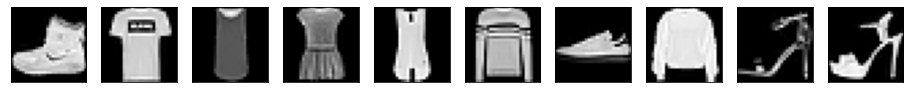

In [3]:
# Train Data
plt.figure(figsize=(16, 10))
for i in range(num_of_class):
    ax = plt.subplot(1, num_of_class, i+1)
    plt.imshow(x_train[i], cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

In [4]:
print('== Before normalization ==')
print('Image Shape:', x_train[0].shape)
print('Value MIN: %d, MEAN:%.2f, MAX:%d'%(np.min(x_train[0]), np.mean(x_train[0]), np.max(x_train[0])))

## Dataset Pre-processing ##
# Normalization
x_train = x_train/255.  
x_test = x_test/255. 

# Reshape(Adding channel)
x_train = x_train.reshape((size_of_train, 28, 28, 1))
x_test = x_test.reshape((size_of_test, 28, 28, 1))

print('\n== After normalization ==')
print('Image Shape:', x_train[0].shape)
print('Value MIN: %d, MEAN:%.2f, MAX:%d'%(np.min(x_train[0]), np.mean(x_train[0]), np.max(x_train[0])))

== Before normalization ==
Image Shape: (28, 28)
Value MIN: 0, MEAN:97.25, MAX:255

== After normalization ==
Image Shape: (28, 28, 1)
Value MIN: 0, MEAN:0.38, MAX:1


In [5]:
from tensorflow.python.ops.nn_ops import conv1d_transpose
def channel_attention(x, filter ,name):
    ####Fill your code####
    
    GAP = tf.keras.layers.GlobalAveragePooling2D(name=name+'_GAP')(x)
    fc1 = tf.keras.layers.Dense(filter,name=name+'_fc1') (GAP)
    sigma1 = tf.keras.layers.ReLU(name=name+'_relu')(fc1)
    fc2 = tf.keras.layers.Dense(filter,name=name+'_fc2') (sigma1)
    sigma2 = tf.sigmoid(fc2,name=name+'_sigmoid')
    #r = 4
    x = tf.keras.layers.Multiply(name = name+'_multiply')([x,sigma2])

    return  x

def spatial_attention(x, filter, name):
    ####Fill your code####
    conv = tf.keras.layers.Conv2D(filters=filter, 
                               kernel_size=3, strides=(1, 1),
                               padding='same', name=name+'_conv')(x)
    sigma1 = tf.sigmoid(conv,name=name+'_sigmoid')
    x = tf.keras.layers.Multiply(name=name+'_multiply')([x,sigma1])

    return  x
 
def autoencoder_block(x, filter, name): 
    x = tf.keras.layers.Conv2D(filters=filter, kernel_size=3, strides=(1, 1), padding='same', name=name+'_conv')(x)
    x = tf.keras.layers.BatchNormalization(name=name+'_bn')(x)
    x = tf.keras.layers.ReLU(name=name+'_relu')(x)
    return x

In [23]:
##############################################
# Add Attention Block in AutoEncoder network #
##############################################

def autoencoder(input):
    # Encoder
    x = autoencoder_block(input, 16, 'encoder1')

    x = tf.keras.layers.MaxPooling2D((2, 2), name='encoder_pool1')(x)
    x = autoencoder_block(x, 32, 'encoder2')

    x = tf.keras.layers.MaxPooling2D((2, 2), name='encoder_pool2')(x)
    
    encoded_img = autoencoder_block(x, 64, 'encoder3')

    # Decoder
    x = autoencoder_block(encoded_img, 64, 'decoder1')

    x = tf.keras.layers.UpSampling2D((2, 2), name='decoder_up1')(x)
    x = autoencoder_block(x, 32, 'decoder2')
 
    x = tf.keras.layers.UpSampling2D((2, 2), name='decoder_up2')(x)
    x = autoencoder_block(x, 16, 'decoder3')

    decoded_img = tf.keras.layers.Conv2D(filters=1, kernel_size=3, strides=(1, 1), 
                                         activation='sigmoid', padding='same', 
                                         name='last_conv')(x)
    return decoded_img

def autoencoder_channel(input):
    # Encoder
    x = autoencoder_block(input, 16, 'encoder1')
    x = channel_attention(x, 16 ,'en_ch_attention1')

    x = tf.keras.layers.MaxPooling2D((2, 2), name='encoder_pool1')(x)
    x = autoencoder_block(x, 32, 'encoder2')
    x = channel_attention(x, 32,'en_ch_attention2')

    x = tf.keras.layers.MaxPooling2D((2, 2), name='encoder_pool2')(x)
    
    x = autoencoder_block(x, 64, 'encoder3')
    encoded_img = channel_attention(x, 64,'en_ch_attention3')

    # Decoder
    x = autoencoder_block(encoded_img, 64, 'decoder1')
    x = channel_attention(x, 64,'de_ch_attention1')

    x = tf.keras.layers.UpSampling2D((2, 2), name='decoder_up1')(x)
    x = autoencoder_block(x, 32, 'decoder2')
    x = channel_attention(x, 32,'de_ch_attention2')
 
    x = tf.keras.layers.UpSampling2D((2, 2), name='decoder_up2')(x)
    x = autoencoder_block(x, 16, 'decoder3')
    x = channel_attention(x, 16,'de_ch_attention3')

    decoded_img = tf.keras.layers.Conv2D(filters=1, kernel_size=3, strides=(1, 1), 
                                         activation='sigmoid', padding='same', 
                                         name='last_conv')(x)
    return decoded_img    

def autoencoder_spatial(input):
    # Encoder
    x = autoencoder_block(input, 16, 'encoder1')
    x = spatial_attention(x, 16 ,'en_sp_attention1')

    x = tf.keras.layers.MaxPooling2D((2, 2), name='encoder_pool1')(x)
    x = autoencoder_block(x, 32, 'encoder2')
    x = spatial_attention(x, 32,'en_sp_attention2')

    x = tf.keras.layers.MaxPooling2D((2, 2), name='encoder_pool2')(x)
    
    x = autoencoder_block(x, 64, 'encoder3')
    encoded_img = spatial_attention(x, 64,'en_sp_attention3')

    # Decoder
    x = autoencoder_block(encoded_img, 64, 'decoder1')
    x = spatial_attention(x, 64,'de_sp_attention1')

    x = tf.keras.layers.UpSampling2D((2, 2), name='decoder_up1')(x)
    x = autoencoder_block(x, 32, 'decoder2')
    x = spatial_attention(x, 32,'de_sp_attention2')
 
    x = tf.keras.layers.UpSampling2D((2, 2), name='decoder_up2')(x)
    x = autoencoder_block(x, 16, 'decoder3')
    x = spatial_attention(x, 16,'de_sp_attention3')

    decoded_img = tf.keras.layers.Conv2D(filters=1, kernel_size=3, strides=(1, 1), 
                                         activation='sigmoid', padding='same', 
                                         name='last_conv')(x)
    return decoded_img    


def autoencoder_sirial(input):
    # Encoder
    x = autoencoder_block(input, 16, 'encoder1')
    x = channel_attention(x, 16 ,'en_ch_attention1')
    x = spatial_attention(x, 16 ,'en_sp_attention1')

    x = tf.keras.layers.MaxPooling2D((2, 2), name='encoder_pool1')(x)
    x = autoencoder_block(x, 32, 'encoder2')
    x = channel_attention(x, 32 ,'en_ch_attention2')
    x = spatial_attention(x, 32,'en_sp_attention2')

    x = tf.keras.layers.MaxPooling2D((2, 2), name='encoder_pool2')(x)
    
    x = autoencoder_block(x, 64, 'encoder3')
    x = channel_attention(x, 64 ,'en_ch_attention3')
    encoded_img = spatial_attention(x, 64,'en_sp_attention3')

    # Decoder
    x = autoencoder_block(encoded_img, 64, 'decoder1')
    x = channel_attention(x, 64 ,'de_ch_attention1')
    x = spatial_attention(x, 64,'de_sp_attention1')

    x = tf.keras.layers.UpSampling2D((2, 2), name='decoder_up1')(x)
    x = autoencoder_block(x, 32, 'decoder2')
    x = channel_attention(x, 32 ,'de_ch_attention2')
    x = spatial_attention(x, 32,'de_sp_attention2')
 
    x = tf.keras.layers.UpSampling2D((2, 2), name='decoder_up2')(x)
    x = autoencoder_block(x, 16, 'decoder3')
    x = channel_attention(x, 16 ,'de_ch_attention3')
    x = spatial_attention(x, 16,'de_sp_attention3')

    decoded_img = tf.keras.layers.Conv2D(filters=1, kernel_size=3, strides=(1, 1), 
                                         activation='sigmoid', padding='same', 
                                         name='last_conv')(x)
    return decoded_img    

def autoencoder_parallel(input):
    # Encoder
    x = autoencoder_block(input, 16, 'encoder1')
    x1 = channel_attention(x, 16 ,'en_ch_attention1')
    x2 = spatial_attention(x, 16 ,'en_sp_attention1')
    x = tf.keras.layers.Add(name = 'en_add1') ([x1,x2])

    x = tf.keras.layers.MaxPooling2D((2, 2), name='encoder_pool1')(x)
    x = autoencoder_block(x, 32, 'encoder2')
    x1 = channel_attention(x, 32 ,'en_ch_attention2')
    x2 = spatial_attention(x, 32,'en_sp_attention2')
    x = tf.keras.layers.Add(name = 'en_add2') ([x1,x2])

    x = tf.keras.layers.MaxPooling2D((2, 2), name='encoder_pool2')(x)
    
    x = autoencoder_block(x, 64, 'encoder3')
    x1 = channel_attention(x, 64 ,'en_ch_attention3')
    x2 = spatial_attention(x, 64,'en_sp_attention3')
    encoded_img = tf.keras.layers.Add(name = 'en_add3') ([x1,x2])

    # Decoder
    x = autoencoder_block(encoded_img, 64, 'decoder1')
    x1 = channel_attention(x, 64 ,'de_ch_attention1')
    x2 = spatial_attention(x, 64,'de_sp_attention1')
    x = tf.keras.layers.Add(name = 'de_add1') ([x1,x2])

    x = tf.keras.layers.UpSampling2D((2, 2), name='decoder_up1')(x)
    x = autoencoder_block(x, 32, 'decoder2')
    x1 = channel_attention(x, 32 ,'de_ch_attention2')
    x2 = spatial_attention(x, 32,'de_sp_attention2')
    x = tf.keras.layers.Add(name = 'de_add2') ([x1,x2])

    x = tf.keras.layers.UpSampling2D((2, 2), name='decoder_up2')(x)
    x = autoencoder_block(x, 16, 'decoder3')
    x1 = channel_attention(x, 16 ,'de_ch_attention3')
    x2 = spatial_attention(x, 16,'de_sp_attention3')
    x = tf.keras.layers.Add(name = 'de_add3') ([x1,x2])

    decoded_img = tf.keras.layers.Conv2D(filters=1, kernel_size=3, strides=(1, 1), 
                                         activation='sigmoid', padding='same', 
                                         name='last_conv')(x)
    return decoded_img    


# Normal AutoEncoder Model Create / Summary
input_data = tf.keras.Input(shape=(28, 28, 1))

output_data = autoencoder(input_data)
output_channel_data = autoencoder_channel(input_data)
output_spatial_data = autoencoder_spatial(input_data)
output_sirial_data = autoencoder_sirial(input_data)
output_parallel_data = autoencoder_parallel(input_data)

model = tf.keras.Model(inputs=input_data, outputs=output_data)
model_channel  = tf.keras.Model(inputs=input_data, outputs=output_channel_data)
model_spatial = tf.keras.Model(inputs=input_data, outputs=output_spatial_data)
model_sirial  = tf.keras.Model(inputs=input_data, outputs=output_sirial_data)
model_parallel = tf.keras.Model(inputs=input_data, outputs=output_parallel_data)

model.summary()
model_channel.summary()
model_spatial.summary()
model_sirial.summary()
model_parallel.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 encoder1_conv (Conv2D)      (None, 28, 28, 16)        160       
                                                                 
 encoder1_bn (BatchNormaliza  (None, 28, 28, 16)       64        
 tion)                                                           
                                                                 
 encoder1_relu (ReLU)        (None, 28, 28, 16)        0         
                                                                 
 encoder_pool1 (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 encoder2_conv (Conv2D)      (None, 14, 14, 32)        4640

In [25]:
# Model Compile
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['mse'])
model_channel.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.MeanSquaredError(), metrics=['mse'])
model_spatial.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['mse'])
model_sirial.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['mse'])
model_parallel.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['mse'])

In [26]:
# Training
print('Training Nomal Model')

# AutoEncoder는 input과 output이 같으므로 x_train을 넣어줌
history = model.fit(x_train, x_train, 
                    batch_size=16, 
                    epochs=20,
                    shuffle=True,
                    validation_data=(x_test, x_test))

print('Training Channel Model')
history_channel = model_channel.fit(x_train, x_train, 
                    batch_size=16, 
                    epochs=20,
                    shuffle=True,
                    validation_data=(x_test, x_test)
                    )

print('Training Spatial Model')
history_spatial = model_spatial.fit(x_train, x_train, 
                    batch_size=16, 
                    epochs=20,
                    shuffle=True,
                    validation_data=(x_test, x_test)
                    )

print('Training Sirial Model')
history_sirial = model_sirial.fit(x_train, x_train, 
                    batch_size=16, 
                    epochs=20,
                    shuffle=True,
                    validation_data=(x_test, x_test)
                    )

print('Training Parallel Model')
history_parallel = model_parallel.fit(x_train, x_train, 
                    batch_size=16, 
                    epochs=20,
                    shuffle=True,
                    validation_data=(x_test, x_test)
                    )


Training Model
Epoch 1/20
3750/3750 [==============================] - 42s 11ms/step - loss: 0.0063 - mse: 0.0063 - val_loss: 0.0036 - val_mse: 0.0036
Epoch 2/20
3750/3750 [==============================] - 50s 13ms/step - loss: 0.0033 - mse: 0.0033 - val_loss: 0.0036 - val_mse: 0.0036
Epoch 3/20
3750/3750 [==============================] - 48s 13ms/step - loss: 0.0028 - mse: 0.0028 - val_loss: 0.0026 - val_mse: 0.0026
Epoch 4/20
3750/3750 [==============================] - 48s 13ms/step - loss: 0.0025 - mse: 0.0025 - val_loss: 0.0024 - val_mse: 0.0024
Epoch 5/20
3750/3750 [==============================] - 50s 13ms/step - loss: 0.0024 - mse: 0.0024 - val_loss: 0.0023 - val_mse: 0.0023
Epoch 6/20
3750/3750 [==============================] - 46s 12ms/step - loss: 0.0023 - mse: 0.0023 - val_loss: 0.0024 - val_mse: 0.0024
Epoch 7/20
3750/3750 [==============================] - 49s 13ms/step - loss: 0.0022 - mse: 0.0022 - val_loss: 0.0021 - val_mse: 0.0021
Epoch 8/20
3750/3750 [===========

In [32]:
# Model Predict
recons = model.predict(x_test)
recons_channel = model_channel.predict(x_test)
recons_spatial = model_spatial.predict(x_test)
recons_sirial = model_sirial.predict(x_test)
recons_parallel = model_parallel.predict(x_test)

In [33]:
recons = recons.reshape(-1, 28, 28)
recons_channel = recons_channel.reshape(-1, 28, 28)
recons_spatial = recons_spatial.reshape(-1, 28, 28)
recons_sirial = recons_sirial.reshape(-1, 28, 28)
recons_parallel = recons_parallel.reshape(-1, 28, 28)

test_imgs = (x_test * 255).reshape(-1, 28, 28)

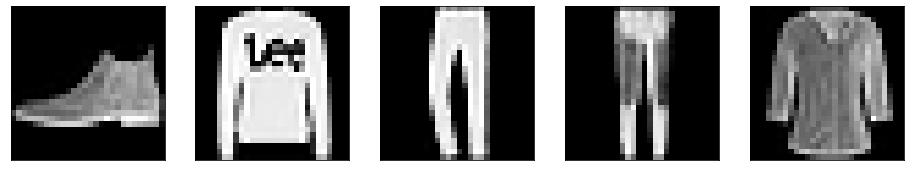

In [34]:
# Test Data Visualization
fig = plt.figure(figsize=(16, 10))

for i in range(5):
    axes = fig.add_subplot(1, 5, i+1)
    axes.imshow(test_imgs[i], cmap='gray')
    axes.set_xticks([])
    axes.set_yticks([])

plt.show()

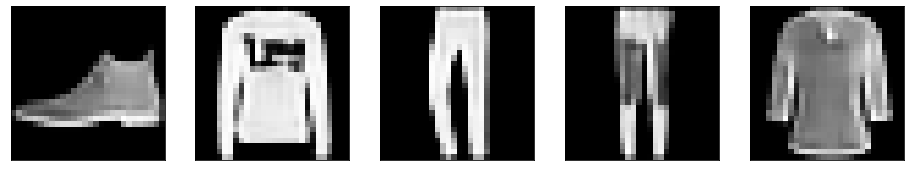

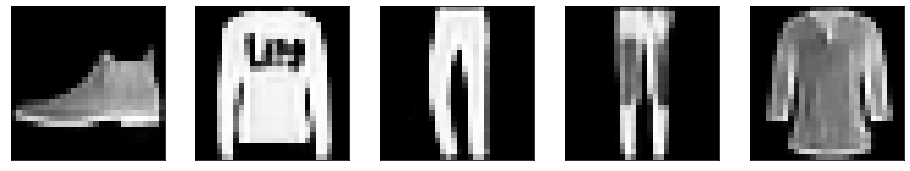

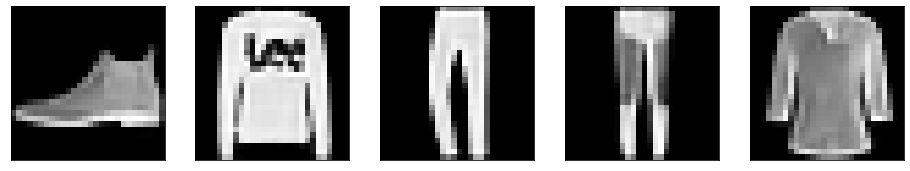

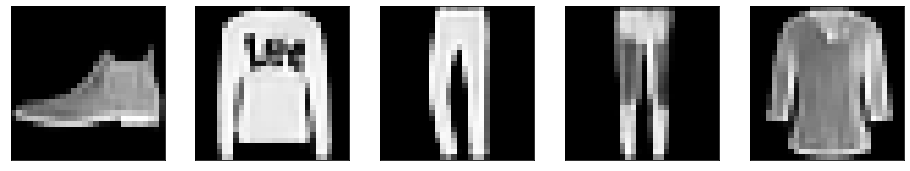

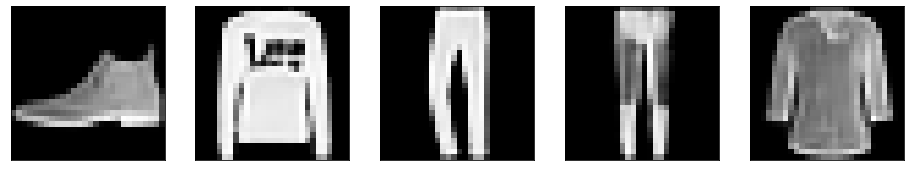

In [53]:
# Predictions Visualization
fig = plt.figure(figsize=(16, 10))


for i in range(5):
    axes = fig.add_subplot(1, 5, i+1)
    axes.imshow(recons[i], cmap='gray')
    axes.set_xticks([])
    axes.set_yticks([])
    

fig = plt.figure(figsize=(16, 10))
for i in range(5):
    axes = fig.add_subplot(1, 5, i+1)
    axes.imshow(recons_channel[i], cmap='gray')
    axes.set_xticks([])
    axes.set_yticks([])

fig = plt.figure(figsize=(16, 10))
for i in range(5):
    axes = fig.add_subplot(1, 5, i+1)
    axes.imshow(recons_spatial[i], cmap='gray')
    axes.set_xticks([])
    axes.set_yticks([])

fig = plt.figure(figsize=(16, 10))
for i in range(5):
    axes = fig.add_subplot(1, 5, i+1)
    axes.imshow(recons_sirial[i], cmap='gray')
    axes.set_xticks([])
    axes.set_yticks([])

fig = plt.figure(figsize=(16, 10))
for i in range(5):
    axes = fig.add_subplot(1, 5, i+1)
    axes.imshow(recons_parallel[i], cmap='gray')
    axes.set_xticks([])
    axes.set_yticks([])

plt.show()

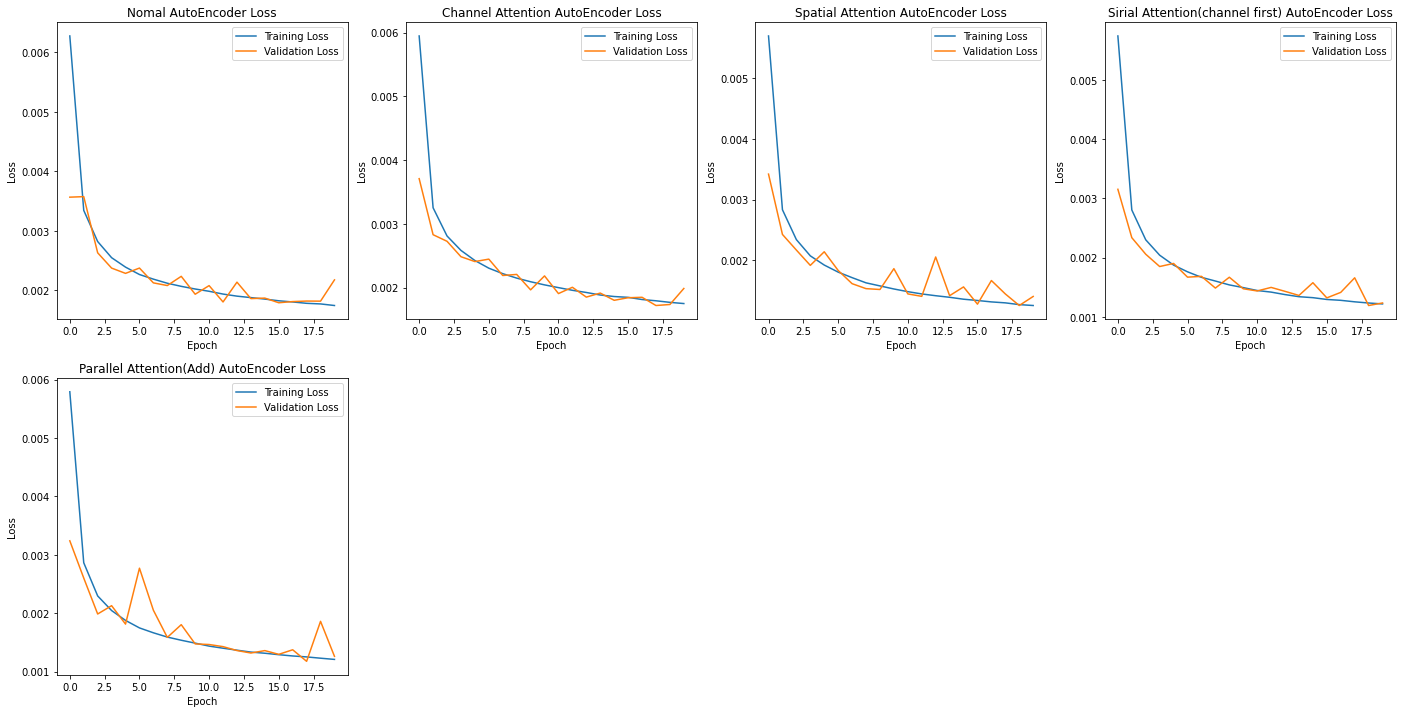

In [54]:
import matplotlib.pyplot as plt
plt.figure(figsize=(24,12))
plt.subplot(2,4,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Nomal AutoEncoder Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc=0)

plt.subplot(2,4,2)
plt.plot(history_channel.history['loss'])
plt.plot(history_channel.history['val_loss'])
plt.title('Channel Attention AutoEncoder Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc=0)

plt.subplot(2,4,3)
plt.plot(history_spatial.history['loss'])
plt.plot(history_spatial.history['val_loss'])
plt.title('Spatial Attention AutoEncoder Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc=0)

plt.subplot(2,4,4)
plt.plot(history_sirial.history['loss'])
plt.plot(history_sirial.history['val_loss'])
plt.title('Sirial Attention(channel first) AutoEncoder Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc=0)

plt.subplot(2,4,5)
plt.plot(history_parallel.history['loss'])
plt.plot(history_parallel.history['val_loss'])
plt.title('Parallel Attention(Add) AutoEncoder Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc=0)

plt.show()